# How to handle Unbalanced Dataset in a Credit Scoring Model
# Resampling Methods + Stratified Cross-Validation

## Prepare Workspace

In [1]:
# Upload Libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import itertools

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Using TensorFlow backend.


/kaggle/input/hmeq-data/hmeq.csv


In [2]:
# Upload Dataset
dataset = pd.read_csv('../input/hmeq-data/hmeq.csv')
# Target variable
y = dataset.BAD
dataset.drop(['BAD'], axis=1, inplace=True)

## Summarize Dataset

In [3]:
# dimensions of dataset
print(dataset.shape)


(5960, 12)


In [4]:
# columns of dataset
dataset.columns


Index(['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ',
       'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [5]:
# list types for each attribute
dataset.dtypes


LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [6]:
# take a peek at the first rows of the data
dataset.head(50)


,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
5,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
6,1800,48649.0,57037.0,HomeImp,Other,5.0,3.0,2.0,77.100000,1.0,17.0,NaN
7,1800,28502.0,43034.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
8,2000,32700.0,46740.0,HomeImp,Other,3.0,0.0,2.0,216.933333,1.0,12.0,NaN
9,2000,NaN,62250.0,HomeImp,Sales,16.0,0.0,0.0,115.800000,0.0,13.0,NaN


In [7]:
# summarize attribute distributions for data frame
print(dataset.describe().T)


          count           mean           std          min           25%  \
LOAN     5960.0   18607.969799  11207.480417  1100.000000  11100.000000   
MORTDUE  5442.0   73760.817200  44457.609458  2063.000000  46276.000000   
VALUE    5848.0  101776.048741  57385.775334  8000.000000  66075.500000   
YOJ      5445.0       8.922268      7.573982     0.000000      3.000000   
DEROG    5252.0       0.254570      0.846047     0.000000      0.000000   
DELINQ   5380.0       0.449442      1.127266     0.000000      0.000000   
CLAGE    5652.0     179.766275     85.810092     0.000000    115.116702   
NINQ     5450.0       1.186055      1.728675     0.000000      0.000000   
CLNO     5738.0      21.296096     10.138933     0.000000     15.000000   
DEBTINC  4693.0      33.779915      8.601746     0.524499     29.140031   

                  50%            75%            max  
LOAN     16300.000000   23300.000000   89900.000000  
MORTDUE  65019.000000   91488.000000  399550.000000  
VALUE    892

In [8]:
print(dataset.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 12 columns):
LOAN       5960 non-null int64
MORTDUE    5442 non-null float64
VALUE      5848 non-null float64
REASON     5708 non-null object
JOB        5681 non-null object
YOJ        5445 non-null float64
DEROG      5252 non-null float64
DELINQ     5380 non-null float64
CLAGE      5652 non-null float64
NINQ       5450 non-null float64
CLNO       5738 non-null float64
DEBTINC    4693 non-null float64
dtypes: float64(9), int64(1), object(2)
memory usage: 558.9+ KB
None


In [9]:
def rstr(dataset): return dataset.shape, dataset.apply(lambda x: [x.unique()])
print(rstr(dataset))

((5960, 12), LOAN       [[1100, 1300, 1500, 1700, 1800, 2000, 2100, 22...
MORTDUE    [[25860.0, 70053.0, 13500.0, nan, 97800.0, 305...
VALUE      [[39025.0, 68400.0, 16700.0, nan, 112000.0, 40...
REASON                             [[HomeImp, nan, DebtCon]]
JOB        [[Other, nan, Office, Sales, Mgr, ProfExe, Self]]
YOJ        [[10.5, 7.0, 4.0, nan, 3.0, 9.0, 5.0, 11.0, 16...
DEROG      [[0.0, nan, 3.0, 2.0, 1.0, 4.0, 5.0, 6.0, 7.0,...
DELINQ     [[0.0, 2.0, nan, 1.0, 6.0, 15.0, 4.0, 3.0, 5.0...
CLAGE      [[94.366666667, 121.83333333, 149.46666667, na...
NINQ       [[1.0, 0.0, nan, 2.0, 3.0, 5.0, 14.0, 10.0, 4....
CLNO       [[9.0, 14.0, 10.0, nan, 8.0, 17.0, 12.0, 13.0,...
DEBTINC    [[nan, 37.113613558000004, 36.884894093, 3.711...
dtype: object)


In [10]:
# Look at the level of each feature
for column in dataset.columns:
    print(column, dataset[column].nunique())

LOAN 540
MORTDUE 5053
VALUE 5381
REASON 2
JOB 6
YOJ 99
DEROG 11
DELINQ 14
CLAGE 5314
NINQ 16
CLNO 62
DEBTINC 4693


## Handling Missing Values

In [11]:
# check missing values both to numeric features and categorical features 
feat_missing = []

for f in dataset.columns:
    missings = dataset[f].isnull().sum()
    if missings > 0:
        feat_missing.append(f)
        missings_perc = missings/dataset.shape[0]
        
        # printing summary of missing values
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))

# how many variables do present missing values?
print()
print('In total, there are {} variables with missing values'.format(len(feat_missing)))

Variable MORTDUE has 518 records (8.69%) with missing values
Variable VALUE has 112 records (1.88%) with missing values
Variable REASON has 252 records (4.23%) with missing values
Variable JOB has 279 records (4.68%) with missing values
Variable YOJ has 515 records (8.64%) with missing values
Variable DEROG has 708 records (11.88%) with missing values
Variable DELINQ has 580 records (9.73%) with missing values
Variable CLAGE has 308 records (5.17%) with missing values
Variable NINQ has 510 records (8.56%) with missing values
Variable CLNO has 222 records (3.72%) with missing values
Variable DEBTINC has 1267 records (21.26%) with missing values

In total, there are 11 variables with missing values


In [12]:
# imputing missing values 
dataset = dataset.fillna(method='ffill')
dataset = dataset.fillna(method='bfill')




## Target Variable Analysis

In [13]:
# summarize the class distribution
y = y.astype(object) 
count = pd.crosstab(index = y, columns="count")
percentage = pd.crosstab(index = y, columns="frequency")/pd.crosstab(index = y, columns="frequency").sum()
pd.concat([count, percentage], axis=1)

col_0,count,frequency
BAD,,
0,4771,0.800503
1,1189,0.199497


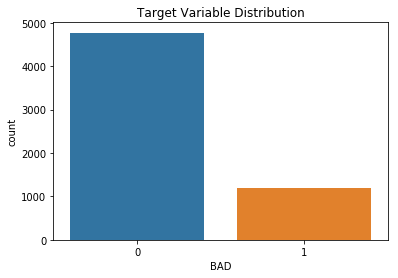

In [14]:
ax = sns.countplot(x=y, data=dataset).set_title("Target Variable Distribution")

## Categorical Variables Visualization

In [15]:
# categorical features
categorical_cols = [cname for cname in dataset.columns if
                    dataset[cname].dtype in ['object']]
cat = dataset[categorical_cols]
cat.columns

Index(['REASON', 'JOB'], dtype='object')

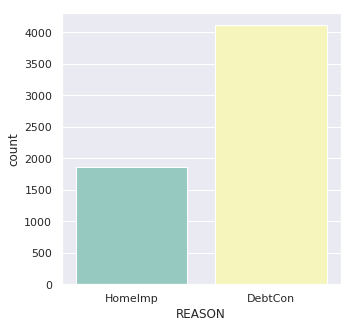

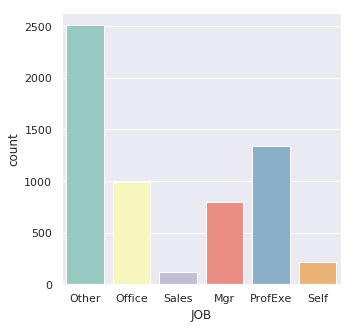

In [16]:
# Visualizations
sns.set( rc = {'figure.figsize': (5, 5)})
fcat = ['REASON','JOB']

for col in fcat:
    plt.figure()
    sns.countplot(x=cat[col], data=cat, palette="Set3")
    plt.show()

### Encoding Categorical Variables

In [17]:
# One-hot encode the data
HOX_dataset = pd.get_dummies(dataset)

## Numerical Variables Visualization

In [18]:
# Numerical features
numerical_cols = [cname for cname in dataset.columns if
                 dataset[cname].dtype in ['float']]
num = dataset[numerical_cols]
num.columns

Index(['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO',
       'DEBTINC'],
      dtype='object')

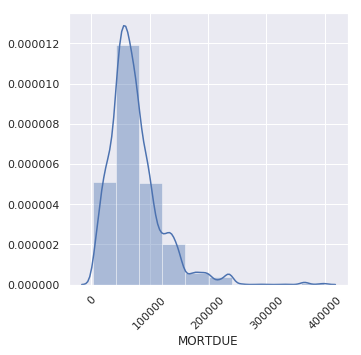

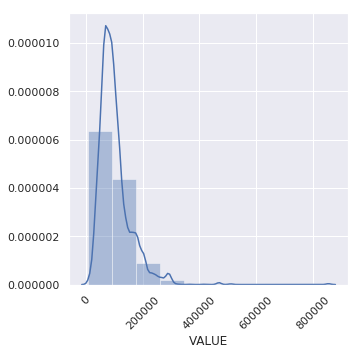

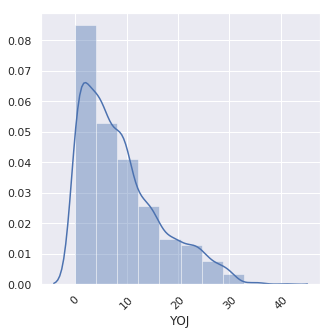

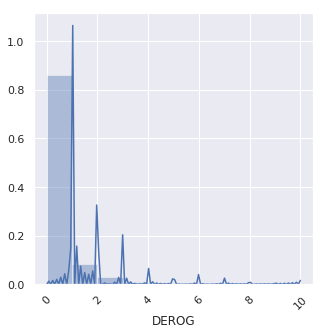

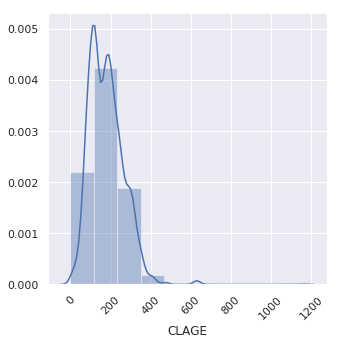

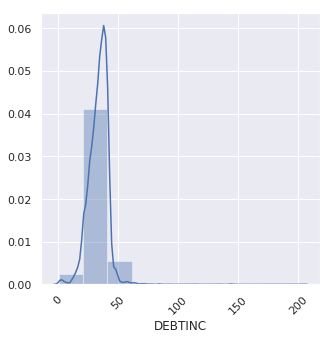

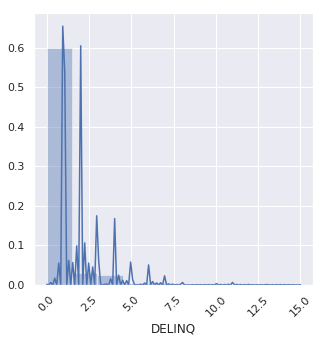

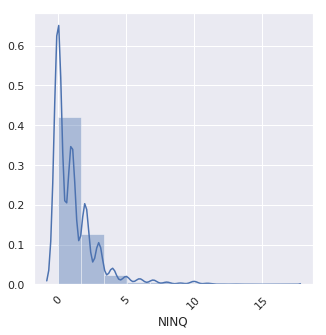

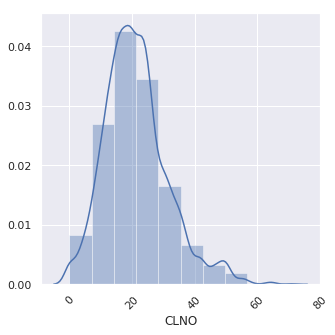

In [19]:
# Visualizations
sns.set( rc = {'figure.figsize': (5, 5)})
fnum = ['MORTDUE','VALUE','YOJ','DEROG','CLAGE','DEBTINC','DELINQ','NINQ','CLNO']

for col in fnum:
    plt.figure()
    x=num[col]
    sns.distplot(x, bins=10)
    plt.xticks(rotation=45)
    plt.show()

## Resampling Techniques + Stratified Cross-Validation

## Split Dataset

In [20]:
# Break off train and validation set from training data
y = y.astype('int') 
X_train, X_valid, y_train, y_valid = train_test_split(HOX_dataset, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

### SMOTE + Stratified Cross-Validation

In [21]:
smo = SMOTE(random_state=0)
X_resampled, y_resampled = smo.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 3817), (1, 3817)]


## Confusion Matrix Function

In [22]:
# From https://www.kaggle.com/ajay1735/my-credit-scoring-model
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Baseline Models 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Confusion matrix, without normalization
[[730 224]
 [ 81 157]]
Confusion matrix, without normalization
[[922  32]
 [103 135]]


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Confusion matrix, without normalization
[[926  28]
 [116 122]]
Confusion matrix, without normalization
[[845 109]
 [115 123]]
Confusion matrix, without normalization
[[883  71]
 [124 114]]


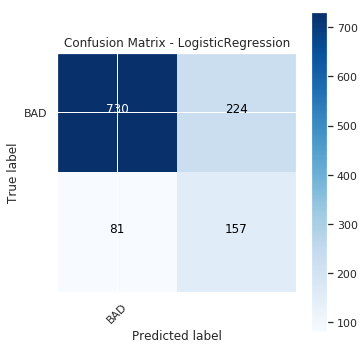

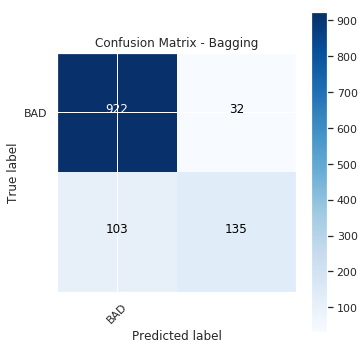

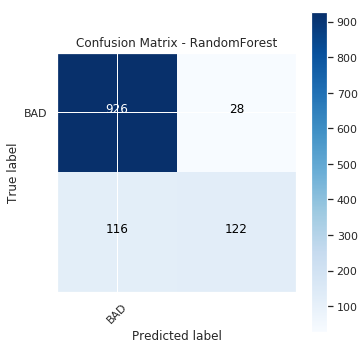

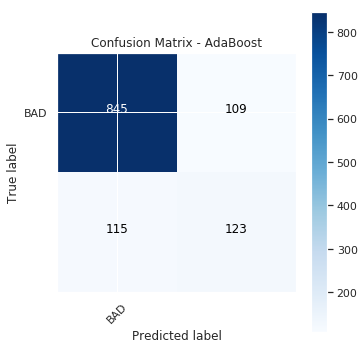

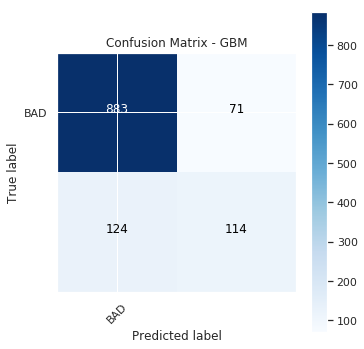

In [23]:
# Test options and evaluation metric

# Spot Check Algorithms
models = []
models.append(('LogisticRegression', LogisticRegression(random_state=0)))
models.append(('Bagging', BaggingClassifier(random_state=0)))
models.append(('RandomForest', RandomForestClassifier(random_state=0)))
models.append(('AdaBoost', AdaBoostClassifier(random_state=0)))
models.append(('GBM', GradientBoostingClassifier(random_state=0)))
results_t = []
results_v = []
names = []
score = []
skf = StratifiedKFold(n_splits=5)
for (name, model) in models:
    param_grid = {}
    my_model = GridSearchCV(model,param_grid,cv=skf)
    my_model.fit(X_resampled, y_resampled)
    predictions_t = my_model.predict(X_resampled) 
    predictions_v = my_model.predict(X_valid)
    accuracy_train = accuracy_score(y_resampled, predictions_t) 
    accuracy_valid = accuracy_score(y_valid, predictions_v) 
    results_t.append(accuracy_train)
    results_v.append(accuracy_valid)
    names.append(name)
    f_dict = {
        'model': name,
        'accuracy_train': accuracy_train,
        'accuracy_valid': accuracy_valid,
    }
    # Computing Confusion matrix for the above algorithm
    cnf_matrix = confusion_matrix(y_valid, predictions_v)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["BAD"], title="Confusion Matrix - "+str(name))
    score.append(f_dict)
plt.show()    
score = pd.DataFrame(score, columns = ['model','accuracy_train', 'accuracy_valid'])

In [24]:
print(score)

                model  accuracy_train  accuracy_valid
0  LogisticRegression        0.743909        0.744128
1             Bagging        0.995546        0.886745
2        RandomForest        0.996725        0.879195
3            AdaBoost        0.878832        0.812081
4                 GBM        0.911842        0.836409


## Scaled Baseline Models 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Confusion matrix, without normalization
[[728 226]
 [ 83 155]]
Confusion matrix, without normalization
[[922  32]
 [103 135]]


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Confusion matrix, without normalization
[[927  27]
 [116 122]]
Confusion matrix, without normalization
[[845 109]
 [115 123]]
Confusion matrix, without normalization
[[883  71]
 [124 114]]


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

Confusion matrix, without normalization
[[893  61]
 [ 95 143]]


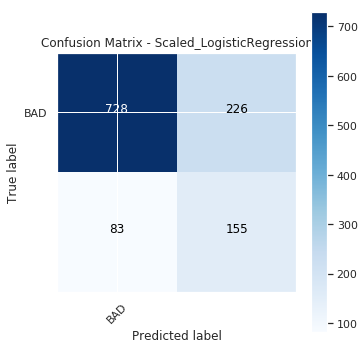

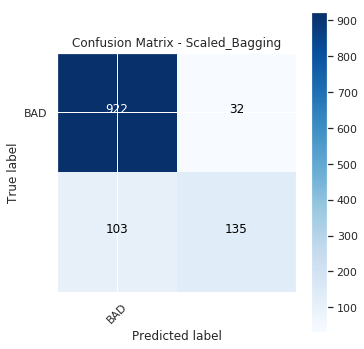

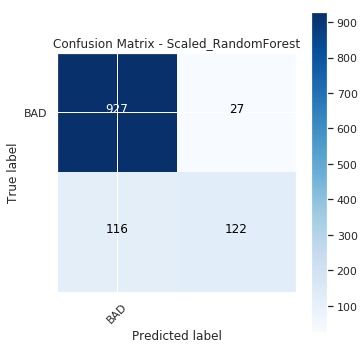

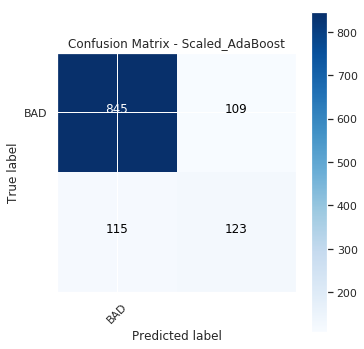

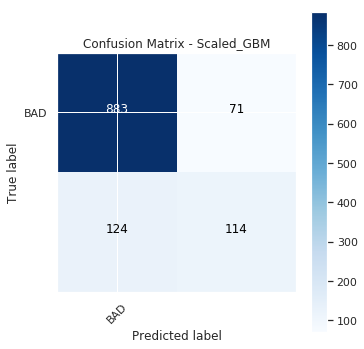

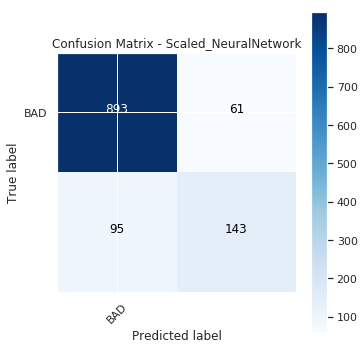

In [25]:
# Spot Check Algorithms with standardized dataset
pipelines = []
pipelines.append(('Scaled_LogisticRegression', Pipeline([('Scaler', StandardScaler()),('LogisticRegression', LogisticRegression(random_state=0))])))
pipelines.append(('Scaled_Bagging', Pipeline([('Scaler', StandardScaler()),('Bagging', BaggingClassifier(random_state=0))])))
pipelines.append(('Scaled_RandomForest', Pipeline([('Scaler', StandardScaler()),('RandomForest', RandomForestClassifier(random_state=0))])))
pipelines.append(('Scaled_AdaBoost', Pipeline([('Scaler', StandardScaler()),('AdaBoost', AdaBoostClassifier(random_state=0))])))
pipelines.append(('Scaled_GBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(random_state=0))])))
pipelines.append(('Scaled_NeuralNetwork', Pipeline([('Scaler', StandardScaler()),('NeuralNetwork', MLPClassifier(random_state=0))])))
results_t = []
results_v = []
names = []
score_sd = []
skf = StratifiedKFold(n_splits=5)
for (name, model) in pipelines:
    param_grid = {}
    my_model = GridSearchCV(model,param_grid,cv=skf)
    my_model.fit(X_resampled, y_resampled)
    predictions_t = my_model.predict(X_resampled) 
    predictions_v = my_model.predict(X_valid)
    accuracy_train = accuracy_score(y_resampled, predictions_t) 
    accuracy_valid = accuracy_score(y_valid, predictions_v) 
    results_t.append(accuracy_train)
    results_v.append(accuracy_valid)
    names.append(name)
    f_dict = {
        'model': name,
        'accuracy_train': accuracy_train,
        'accuracy_valid': accuracy_valid,
    }
    # Computing Confusion matrix for the above algorithm
    cnf_matrix = confusion_matrix(y_valid, predictions_v)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["BAD"], title="Confusion Matrix - "+str(name))
    score_sd.append(f_dict)
plt.show()   
score_sd = pd.DataFrame(score_sd, columns = ['model','accuracy_train', 'accuracy_valid'])

In [26]:
print(score_sd)

                       model  accuracy_train  accuracy_valid
0  Scaled_LogisticRegression        0.744826        0.740772
1             Scaled_Bagging        0.995546        0.886745
2        Scaled_RandomForest        0.996856        0.880034
3            Scaled_AdaBoost        0.878832        0.812081
4                 Scaled_GBM        0.911842        0.836409
5       Scaled_NeuralNetwork        0.953759        0.869128


## Split Dataset

In [27]:
# Break off train and validation set from training data
y = y.astype('int') 
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(HOX_dataset, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

### ADASYN + Stratified Cross-Validation

In [28]:
ada = ADASYN(random_state=0)
X_resampled_, y_resampled_ = ada.fit_resample(X_train_, y_train_)
print(sorted(Counter(y_resampled_).items()))

[(0, 3817), (1, 3690)]


## Baseline Models 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Confusion matrix, without normalization
[[743 211]
 [ 85 153]]
Confusion matrix, without normalization
[[927  27]
 [114 124]]


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Confusion matrix, without normalization
[[929  25]
 [107 131]]
Confusion matrix, without normalization
[[857  97]
 [118 120]]
Confusion matrix, without normalization
[[888  66]
 [131 107]]


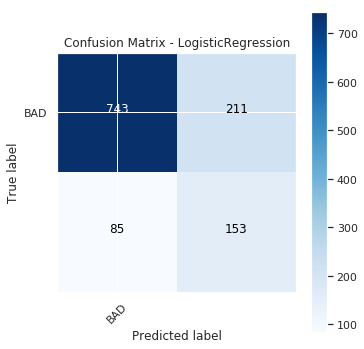

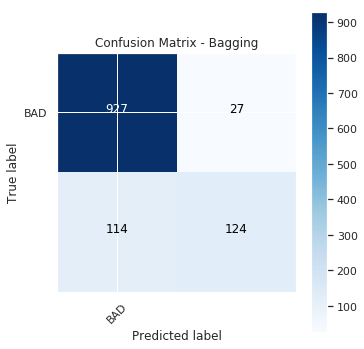

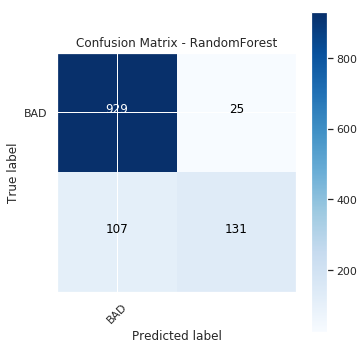

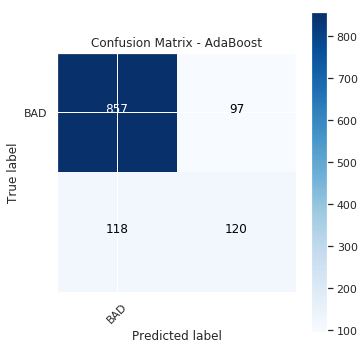

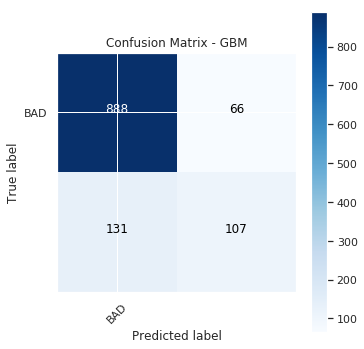

In [29]:
# Test options and evaluation metric

# Spot Check Algorithms
models = []
models.append(('LogisticRegression', LogisticRegression(random_state=0)))
models.append(('Bagging', BaggingClassifier(random_state=0)))
models.append(('RandomForest', RandomForestClassifier(random_state=0)))
models.append(('AdaBoost', AdaBoostClassifier(random_state=0)))
models.append(('GBM', GradientBoostingClassifier(random_state=0)))
results_t = []
results_v = []
names = []
score = []
skf = StratifiedKFold(n_splits=5)
for (name, model) in models:
    param_grid = {}
    my_model = GridSearchCV(model,param_grid,cv=skf)
    my_model.fit(X_resampled_, y_resampled_)
    predictions_t = my_model.predict(X_resampled_) 
    predictions_v = my_model.predict(X_valid_)
    accuracy_train = accuracy_score(y_resampled_, predictions_t) 
    accuracy_valid = accuracy_score(y_valid_, predictions_v) 
    results_t.append(accuracy_train)
    results_v.append(accuracy_valid)
    names.append(name)
    f_dict = {
        'model': name,
        'accuracy_train': accuracy_train,
        'accuracy_valid': accuracy_valid,
    }
    # Computing Confusion matrix for the above algorithm
    cnf_matrix = confusion_matrix(y_valid_, predictions_v)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["BAD"], title="Confusion Matrix - "+str(name))
    score.append(f_dict)
plt.show()    
score = pd.DataFrame(score, columns = ['model','accuracy_train', 'accuracy_valid'])

In [30]:
print(score)

                model  accuracy_train  accuracy_valid
0  LogisticRegression        0.740775        0.751678
1             Bagging        0.995604        0.881711
2        RandomForest        0.996936        0.889262
3            AdaBoost        0.877181        0.819631
4                 GBM        0.912881        0.834732


## Scaled Baseline Models

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Confusion matrix, without normalization
[[746 208]
 [ 85 153]]
Confusion matrix, without normalization
[[927  27]
 [116 122]]


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Confusion matrix, without normalization
[[928  26]
 [107 131]]
Confusion matrix, without normalization
[[857  97]
 [118 120]]
Confusion matrix, without normalization
[[888  66]
 [131 107]]


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

Confusion matrix, without normalization
[[898  56]
 [ 87 151]]


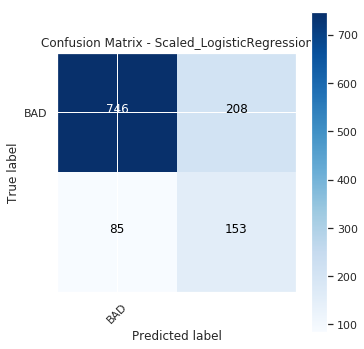

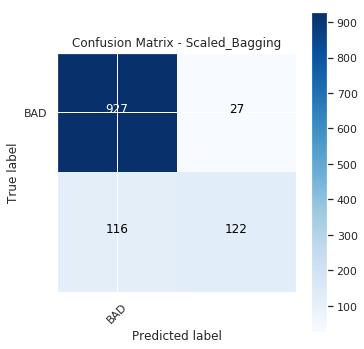

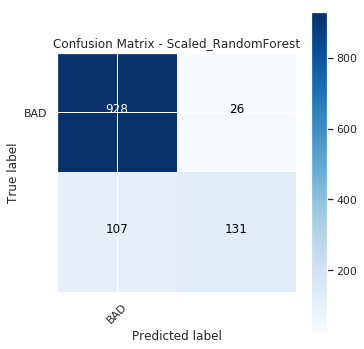

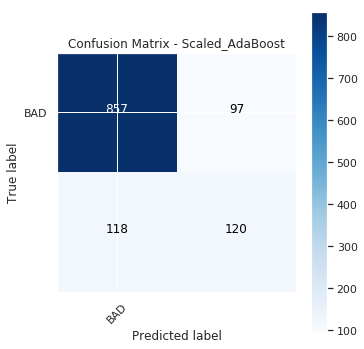

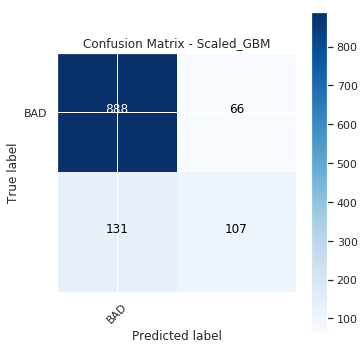

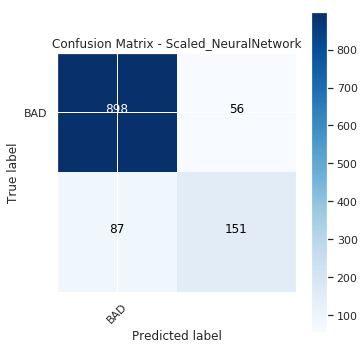

In [31]:
# Spot Check Algorithms with standardized dataset
pipelines = []
pipelines.append(('Scaled_LogisticRegression', Pipeline([('Scaler', StandardScaler()),('LogisticRegression', LogisticRegression(random_state=0))])))
pipelines.append(('Scaled_Bagging', Pipeline([('Scaler', StandardScaler()),('Bagging', BaggingClassifier(random_state=0))])))
pipelines.append(('Scaled_RandomForest', Pipeline([('Scaler', StandardScaler()),('RandomForest', RandomForestClassifier(random_state=0))])))
pipelines.append(('Scaled_AdaBoost', Pipeline([('Scaler', StandardScaler()),('AdaBoost', AdaBoostClassifier(random_state=0))])))
pipelines.append(('Scaled_GBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(random_state=0))])))
pipelines.append(('Scaled_NeuralNetwork', Pipeline([('Scaler', StandardScaler()),('NeuralNetwork', MLPClassifier(random_state=0))])))
results_t = []
results_v = []
names = []
score_sd = []
skf = StratifiedKFold(n_splits=5)
for (name, model) in pipelines:
    param_grid = {}
    my_model = GridSearchCV(model,param_grid,cv=skf)
    my_model.fit(X_resampled_, y_resampled_)
    predictions_t = my_model.predict(X_resampled_) 
    predictions_v = my_model.predict(X_valid_)
    accuracy_train = accuracy_score(y_resampled_, predictions_t) 
    accuracy_valid = accuracy_score(y_valid_, predictions_v) 
    results_t.append(accuracy_train)
    results_v.append(accuracy_valid)
    names.append(name)
    f_dict = {
        'model': name,
        'accuracy_train': accuracy_train,
        'accuracy_valid': accuracy_valid,
    }
    # Computing Confusion matrix for the above algorithm
    cnf_matrix = confusion_matrix(y_valid_, predictions_v)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["BAD"], title="Confusion Matrix - "+str(name))
    score_sd.append(f_dict)
plt.show()   
score_sd = pd.DataFrame(score_sd, columns = ['model','accuracy_train', 'accuracy_valid'])

In [32]:
print(score_sd)

                       model  accuracy_train  accuracy_valid
0  Scaled_LogisticRegression        0.743839        0.754195
1             Scaled_Bagging        0.995604        0.880034
2        Scaled_RandomForest        0.996803        0.888423
3            Scaled_AdaBoost        0.877181        0.819631
4                 Scaled_GBM        0.912881        0.834732
5       Scaled_NeuralNetwork        0.949514        0.880034
